# Лабораторная работа №2

## Задача классификаиции

In [ ]:

path = DecisionTreeRegressor().cost_complexity_pruning_path(X_train_mumb, y_train_mumb)
ccp_alphas = path.ccp_alphas
optimal_alpha = None
best_accuracy = -np.inf 
for alpha in ccp_alphas:
    mean_accuracy = k_fold(DecisionTreeRegressor(ccp_alpha=alpha), X_train_mumb, y_train_mumb, 'r2', False)
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        optimal_alpha = alpha

optimal_alpha


#### Импорты

In [106]:
from ml_library.hyperparams import  optuna_params, gridSearchCV_params, randomizedSearchCV_params
from ml_library.graphics_neo import plot_miss_distance_vs_velocity, plot_magnitude_vs_velocity
from ml_library.graphics import plot_roc_curves
from ml_library.metrics import custom_classifier_metrics
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import joblib


In [107]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def ROC_curve(model, X_test, y_test):
    y_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr,tresholds = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

### Загрузка данных

In [1]:
data = pd.read_csv('result_neo.csv')

NameError: name 'pd' is not defined

In [109]:
#Удалим лишний столбец name
data = data.drop(columns=['name'])
data

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,0.016016,0.035813,56014.080,1024333.0,26.09,0
1,0.030518,0.068240,7864.348,32681860.0,24.70,0
2,0.055533,0.124177,55257.543,65386360.0,23.41,0
3,0.019256,0.043057,41531.406,12607958.0,25.70,0
4,0.139494,0.311918,67639.390,71305896.0,21.41,0
...,...,...,...,...,...,...
82463,0.017561,0.039268,23264.740,1635006.6,25.91,0
82464,0.110804,0.247765,24802.520,33519008.0,21.91,0
82465,0.035039,0.078350,116289.000,54713964.0,24.41,0
82466,0.044112,0.098637,45763.316,26948772.0,23.91,0


### Шаг 1: Выделим целевой признак и предикторы

In [110]:
Y = data['hazardous']
X = data.drop(['hazardous'], axis=1)
Y.head()

0    0
1    0
2    0
3    0
4    0
Name: hazardous, dtype: int64

In [111]:
X.head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
0,0.016016,0.035813,56014.080,1024333.0,26.09
1,0.030518,0.068240,7864.348,32681860.0,24.70
2,0.055533,0.124177,55257.543,65386360.0,23.41
3,0.019256,0.043057,41531.406,12607958.0,25.70
4,0.139494,0.311918,67639.390,71305896.0,21.41


#### Тип задачи классификации

<font size = 4> Все признаки кроме ```hazardous``` являются числовыми непрерывными, а значит задача является __бинарной__</font>

### Шаг 2: Проверим баланс класса

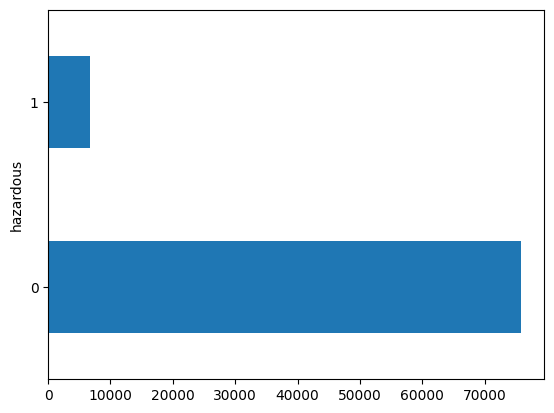

In [112]:
data['hazardous'].value_counts().plot.barh();

<font size =4 > Наблюдается явное преимущество безопасных космических объектов. Распредление данных **неравномерно**</font>

#### Сбалансируем классы

In [113]:
from imblearn.under_sampling import  RandomUnderSampler

# oversample = SMOTE()
# transformed_X, transformed_Y = oversample.fit_resample(X, Y)

undersample = RandomUnderSampler(replacement=True)
transformed_X, transformed_Y = undersample.fit_resample(X,Y)

#### Сохранение данных

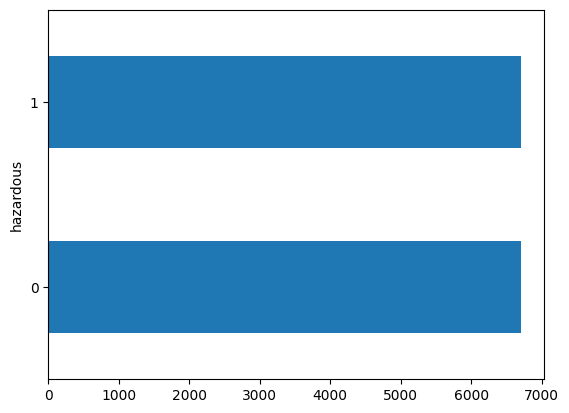

In [114]:
transformed_df = pd.concat([transformed_X, transformed_Y], axis=1, join='outer')
transformed_df['hazardous'].value_counts().plot.barh();

In [115]:
transformed_X

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
71797,0.042126,0.094198,43385.848,24237444.00,24.00
9081,0.004411,0.009864,45698.010,201771.31,23.70
33114,0.105817,0.236614,32263.516,70633180.00,22.00
51852,0.022108,0.049436,45930.695,5711521.00,25.41
59886,0.253837,0.567597,34747.492,56039812.00,20.09
...,...,...,...,...,...
82389,0.150853,0.337318,48243.418,51347500.00,21.23
82399,0.104847,0.234444,66320.030,53792056.00,22.02
82419,0.176423,0.394494,108286.820,43743810.00,20.89
82449,0.201630,0.450858,52389.516,23651644.00,20.59


#### Масштабирование данных

In [116]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(transformed_X)

### Шаг 3: Разделим данные на обучающую и тестовую выборки

**hold-out**

In [117]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, transformed_Y, test_size=0.3)

**k-fold**

In [119]:
def k_fold(model):
    scores  = cross_val_score(model, X_train,y_train, cv = 5, scoring='accuracy')
    print("Оценки кросс-валидации на обучающем наборе", scores)
    print("Средняя оценка кросс-валидации на обучающем наборе", np.mean(scores))

## <span style = "color: #FFA500"> Решение задачи классификации <span>

In [120]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB


### ОБУЧЕНИЕ <span style = "color:rgb(117, 191, 234)">SVM</span> МОДЕЛЕЙ

#### <span style = "color:rgb(117, 191, 234)"> SVC </span> / <span style = "color: rgb(79, 211, 180)"> Linear </span>

In [121]:
svc_linear = SVC(kernel='linear', C=0.1, max_iter = 100000, probability=True)
#svc_linear.fit(X_train, y_train)

In [122]:
svc_linear = joblib.load('svc_linear_model.joblib')

In [123]:
y_pred = svc_linear.predict(X_test)

In [124]:
custom_classifier_metrics(y_test, y_pred)

                 Метрики качества
accuracy_score             0.8811
precision_score            0.8117
recall_score               0.9884
f1_score                   0.8914
Confusion Matrix (Rows: Predicted, Columns: True):
------------------
              Class 0     Class 1
-----------------------------------
Predicted  Class 0  |   1582      455 |
Predicted  Class 1  |     23     1961 |
-----------------------------------


#### <span style = "color:rgb(117, 191, 234)"> SVC </span> / <span style = "color: rgb(253, 149, 122)"> Poly </span>

In [125]:
svc_poly = SVC(kernel='poly', C=10, max_iter = 100000, probability=True)
#svc_poly.fit(X_train, y_train)

In [126]:
svc_poly = joblib.load('svc_poly_model.joblib')

In [127]:
y_pred = svc_poly.predict(X_test)

In [128]:
custom_classifier_metrics(y_test, y_pred)

                 Метрики качества
accuracy_score             0.8893
precision_score            0.8397
recall_score               0.9587
f1_score                   0.8953
Confusion Matrix (Rows: Predicted, Columns: True):
------------------
              Class 0     Class 1
-----------------------------------
Predicted  Class 0  |   1674      363 |
Predicted  Class 1  |     82     1902 |
-----------------------------------


#### <span style = "color:rgb(117, 191, 234)"> SVC </span> / <span style = "color: rgb(193, 10, 46)"> RBF </span>

In [129]:
svc_rbf = SVC(kernel='rbf', C=10, max_iter = 100000, probability=True)
#svc_rbf.fit(X_train, y_train)

In [130]:
svc_rbf = joblib.load('svc_rbf_model.joblib')

In [131]:
y_pred = svc_rbf.predict(X_test)

In [132]:
custom_classifier_metrics(y_test, y_pred)

                 Метрики качества
accuracy_score             0.8811
precision_score            0.8117
recall_score               0.9884
f1_score                   0.8914
Confusion Matrix (Rows: Predicted, Columns: True):
------------------
              Class 0     Class 1
-----------------------------------
Predicted  Class 0  |   1582      455 |
Predicted  Class 1  |     23     1961 |
-----------------------------------


#### <span style = "color:rgb(117, 191, 234)"> SVC </span> / <span style = "color: rgb(142, 153, 246)"> Sigmoid </span>

In [133]:
svc_sigmoid = SVC(kernel='sigmoid', C=10, max_iter = 100000, probability=True)
#svc_sigmoid.fit(X_train, y_train)

In [134]:
svc_sigmoid = joblib.load('svc_sigmoid_model.joblib')

In [135]:
y_pred = svc_sigmoid.predict(X_test)

In [136]:
custom_classifier_metrics(y_test, y_pred)

                 Метрики качества
accuracy_score             0.7804
precision_score            0.7981
recall_score               0.7429
f1_score                   0.7695
Confusion Matrix (Rows: Predicted, Columns: True):
------------------
              Class 0     Class 1
-----------------------------------
Predicted  Class 0  |   1664      373 |
Predicted  Class 1  |    510     1474 |
-----------------------------------


#### Выводы
- Все 4 модели показали неплохие метрики
- Нам важна метрика _Recall_,  так как она учитывает количество ложно-отрицательных (FN) предсказаний опасности космического объекта. (пропущенная угроза)
- Модели <span style = "color:rgb(117, 191, 234) "> SVC</span>: Linear/RBF лучше всех предсказывают опасность космических объектов
- Модель <span style = "color:rgb(117, 191, 234) "> SVC</span>/<span style="color:rgb(253, 149, 122) ">Poly</span> является самой сбалансированной по предсказаниями:

    1. **f1_score** = ${0.90}$

    2. **recall** = ${0.95}$

    3. **accuracy** = ${0.88}$

### Классификаторы ```Logistic Regression```, ```kNN```, ```Naive Bayes```

In [137]:
classifiers_without_SVC = {
    'Logistic Regression': LogisticRegression(), 
    'KNN': KNeighborsClassifier(),
    'Naive bayes': GaussianNB(),
}

In [138]:
for index, (name, classifier) in enumerate(classifiers_without_SVC.items()):

    classifier.fit(X_train, y_train)
    k_fold(classifier)

    y_pred = classifier.predict(X_test)
    print(f"Метрики {name}")
    custom_classifier_metrics(y_test, y_pred)

Оценки кросс-валидации на обучающем наборе [0.89238146 0.88539446 0.89552239 0.88646055 0.88059701]
Средняя оценка кросс-валидации на обучающем наборе 0.8880711746844587
Метрики Logistic Regression
                 Метрики качества
accuracy_score             0.8891
precision_score            0.8270
recall_score               0.9803
f1_score                   0.8971
Confusion Matrix (Rows: Predicted, Columns: True):
------------------
              Class 0     Class 1
-----------------------------------
Predicted  Class 0  |   1630      407 |
Predicted  Class 1  |     39     1945 |
-----------------------------------
Оценки кросс-валидации на обучающем наборе [0.89397975 0.88965885 0.89978678 0.8880597  0.88486141]
Средняя оценка кросс-валидации на обучающем наборе 0.8912692985335898
Метрики KNN
                 Метрики качества
accuracy_score             0.8878
precision_score            0.8366
recall_score               0.9602
f1_score                   0.8942
Confusion Matrix (Rows: 

#### <span style= "color:rgb(133, 247, 201)"  > Выводы </span>

<font size = 4> Без подбора параметров ```Logistic Regression```,  ```KNN```, и ```Naive Bayes``` уже показывают неплохие результаты. 

Подберём оптимальные параметры с помощью **GridSearch** , **RandomisedSearch** и **Optuna**

</font>

### Оптимальные параметры для Logistic Regression,  KNN, и Naive Bayes

- <span style = "color:rgb(240, 102, 102)">Logistic Regression </span>

In [139]:
lr_params = {
    'penalty': ['l1', 'l2', 'elasticnet', 'None'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver':['liblinear', 'saga'],
    'l1_ratio': np.linspace(0,1,10),
}

grid_search_lr = gridSearchCV_params(LogisticRegression(), lr_params, X_train, y_train)


 Лучшие параметры для модели (GridSearchCV) 'C':0.001, 'l1_ratio':0.778, 'penalty':'elasticnet', 'solver':'saga'


In [140]:
joblib.dump(grid_search_lr, 'lr_model.joblib')

['lr_model.joblib']

In [141]:
y_pred = grid_search_lr.predict(X_test)

custom_classifier_metrics(y_test, y_pred)


                 Метрики качества
accuracy_score             0.8931
precision_score            0.8329
recall_score               0.9798
f1_score                   0.9004
Confusion Matrix (Rows: Predicted, Columns: True):
------------------
              Class 0     Class 1
-----------------------------------
Predicted  Class 0  |   1647      390 |
Predicted  Class 1  |     40     1944 |
-----------------------------------


- <span style = "color:rgb(154, 198, 242)">KNN </span>

In [142]:
from scipy.stats import randint

knn_params = {
    'n_neighbors' : randint(1,50),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p':[1,2]
}

random_search_knn = randomizedSearchCV_params(KNeighborsClassifier(), knn_params, X_train, y_train)

Лучшие параметры для модели (RandomizedSearchCV) 'metric':'minkowski', 'n_neighbors':35.0, 'p':2.0, 'weights':'distance'


In [143]:
joblib.dump(random_search_knn,'knn_model.joblib')

['knn_model.joblib']

In [144]:
y_pred_best_knn = random_search_knn.predict(X_test)
custom_classifier_metrics(y_test, y_pred)

                 Метрики качества
accuracy_score             0.8931
precision_score            0.8329
recall_score               0.9798
f1_score                   0.9004
Confusion Matrix (Rows: Predicted, Columns: True):
------------------
              Class 0     Class 1
-----------------------------------
Predicted  Class 0  |   1647      390 |
Predicted  Class 1  |     40     1944 |
-----------------------------------


- <span style = "color:rgb(231, 243, 119)"> Naive bayes </span>

In [145]:
def objective(trial):
    var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
    model = GaussianNB(var_smoothing=var_smoothing)

    scores = cross_val_score(model, X_train,y_train, cv=5,scoring='accuracy')

    return scores.mean()

In [146]:
best_params = optuna_params(objective, 'maximize')

In [147]:
best_model_nb = GaussianNB(**best_params)
best_model_nb.fit(X_train, y_train)

GaussianNB(var_smoothing=0.09990553912660763)

In [148]:
joblib.dump(best_model_nb,'naive_bayes_model.joblib')

['naive_bayes_model.joblib']

In [149]:
y_pred = best_model_nb.predict(X_test)
custom_classifier_metrics(y_test, y_pred)

                 Метрики качества
accuracy_score             0.8824
precision_score            0.8327
recall_score               0.9531
f1_score                   0.8888
Confusion Matrix (Rows: Predicted, Columns: True):
------------------
              Class 0     Class 1
-----------------------------------
Predicted  Class 0  |   1657      380 |
Predicted  Class 1  |     93     1891 |
-----------------------------------


#### Выводы

- Лучшие метрики имеет модель <span style = "color:rgb(154, 198, 242)">KNN </span> c параметрами:
    - ```metric```: minkowski,
    - ```n_neighbors``` : 29,
    - ```p```: 2,
    - ```weights```: distance
- **f1_score**: 0.92,
- **recall**: 0.99
- **accuracy**: 0.92

#### <span style="color: rgb(150, 206, 134)">Итоговая модель классификаторов

In [150]:
total_classifiers = {
    "LogisticRegression": grid_search_lr,
    "kNN": random_search_knn,
    "NaiveBayes": best_model_nb,
    "SVC/linear": svc_linear,
    "SVC/poly": svc_poly,
    "SVC/rbf": svc_rbf,
    "SVC/sigmoid": svc_sigmoid,
}

### Исследование графиков

#### ROC-кривые

In [151]:
plot_roc_curves(classifiers=total_classifiers, X_test=X_test, y_test=y_test)

#### Выводы
- Лучшие показатели у модели kNN (AUC = 0.95), что говорит о почти идеальном различии классов
- Худшие показатели имеет модель SVC/sigmoid

#### <span style= "color:rgb(207, 219, 104)"> График зависимости **kNN** от _k_


In [152]:
k_values = range(1,51)
test_accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    y_pred_knn = knn.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred_knn)

    test_accuracies.append(test_accuracy)


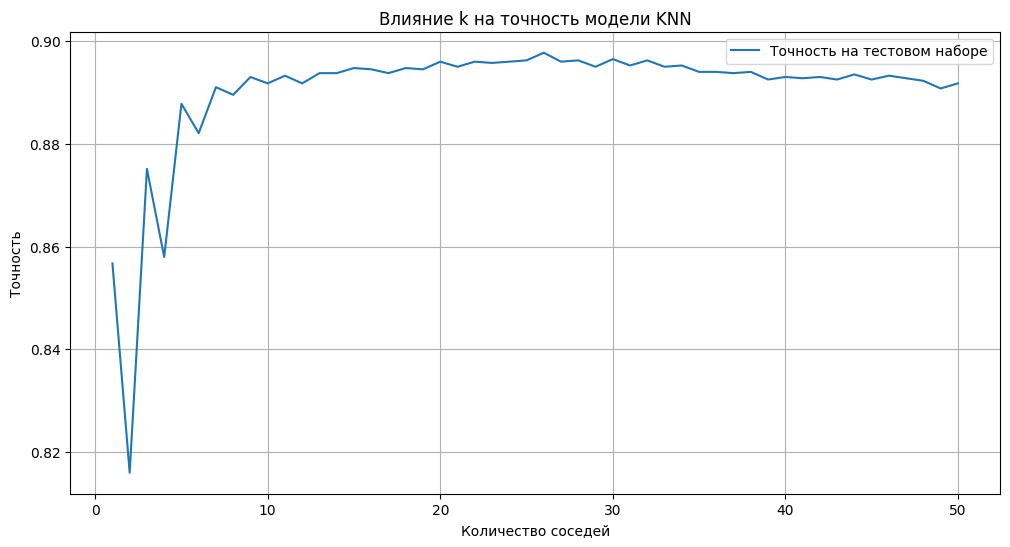

In [153]:
plt.figure(figsize=(12,6))
plt.plot(k_values, test_accuracies, label= "Точность на тестовом наборе")
plt.xlabel('Количество соседей')
plt.ylabel("Точность")
plt.title('Влияние k на точность модели KNN')
plt.legend()
plt.grid(True)
plt.show;

##### Выводы

- Точность модели kNN зависит количества используемых для классификации соседей
- Чем больше соседей, тем стабильнее точность

#### **График зависимости kNN от метрики**

In [154]:
metric_values = ['euclidean','minkowski','manhattan' ]
test_accuracies = []

for metric in metric_values:
    knn = KNeighborsClassifier(n_neighbors=10, metric=metric, p=4)
    knn.fit(X_train,y_train)
    y_pred_knn = knn.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred_knn)

    test_accuracies.append(test_accuracy)

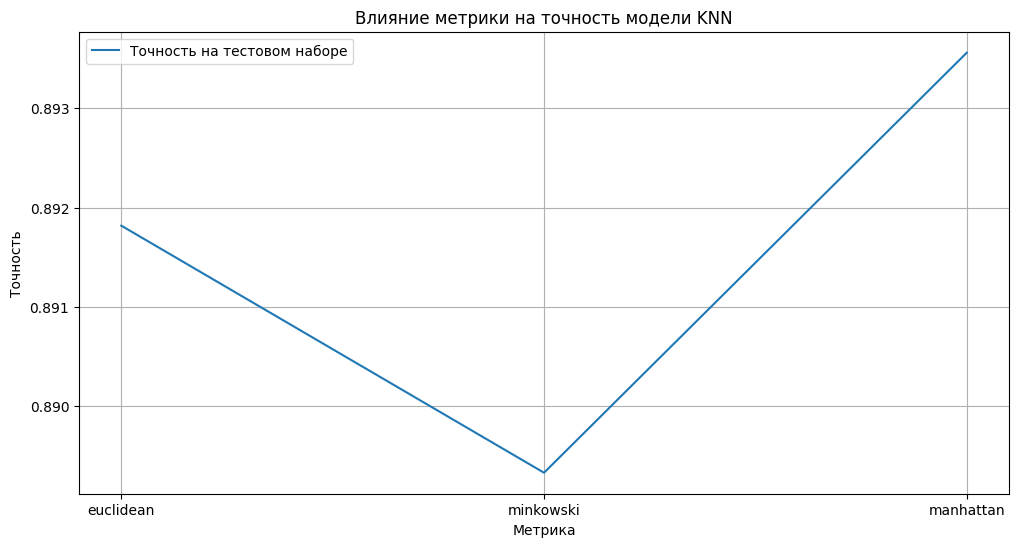

In [155]:
plt.figure(figsize=(12,6))
plt.plot(metric_values, test_accuracies, label= "Точность на тестовом наборе")
plt.xlabel('Метрика')
plt.ylabel("Точность")
plt.title('Влияние метрики на точность модели KNN')
plt.legend()
plt.grid(True)
plt.show;

##### Выводы

- Наилучший результат наблюдается при использовании метрики ```manhattan```

#### График распределения астероидов по расстоянию промаха от Земли и скорости

Наблюдения проводятся на основе модели kNN с лучшими показателями метрик

In [156]:
plot_miss_distance_vs_velocity(X_test, y_test, y_pred_best_knn)

##### Выводы

- Опасность астероидов повышается при небольшом расстоянии промаха и высокой скорости
- Модель использует эту зависимость, выбирая соседей по данным характеристикам, и в основном верно классифицирует объект

#### График распределения астроидов по звёздной величине и скорости

In [157]:
plot_magnitude_vs_velocity(X_test, y_test, y_pred_best_knn)

**KNN КЛАССИФИКАТОР**

In [158]:
from ml_library.models import KNearestNeighbors

In [159]:
knn = KNearestNeighbors()
knn.fit(X_train, y_train)

In [160]:
predict_knn = knn.predict(X_test)

In [161]:
custom_classifier_metrics(y_test, predict_knn)

                 Метрики качества
accuracy_score             0.8878
precision_score            0.8366
recall_score               0.9602
f1_score                   0.8942
Confusion Matrix (Rows: Predicted, Columns: True):
------------------
              Class 0     Class 1
-----------------------------------
Predicted  Class 0  |   1665      372 |
Predicted  Class 1  |     79     1905 |
-----------------------------------


##### Выводы

- Модель имеет хорошую оценку предсказывания 
- Модель хорошо классифицирует опасные астероиды, о чём говорит метрика ```recall_score``` = **0.96**


## <span style= "color:rgb(192, 35, 98)">Выводы по лабораторной работе №3

- Оценивая метрики всех классификаторов, можно выделить несколько моделей, которые лучше справились с задачей:
    - <span style = "color:rgb(117, 191, 234)"> SVC </span> / <span style = "color: rgb(253, 149, 122)"> Poly </span>
    -  <span style = "color:rgb(154, 198, 242)">KNN </span>

Модели достаточно точно классифицируют, и имеют высокий показатель метрики _Recall_, что особенно важно для оценки определения как можно большего числа опасных для Земли астероидов.